- `pip install pandas`
- `pip install pygraphviz`  (problematic with Jupyter Notebook)
- `pip install networkx`
- `pip install matplotlib`

In [1]:
# 3rd-party libraries
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [2]:
N = 10  # Number of trees in simulation
M = 30  # Number of nodes in trees
m = 3  # Minimum number of nodes in subtrees
f = 2  # Minimum frequency of subtree

In [4]:
trees = [nx.random_tree(M, create_using=nx.DiGraph) for i in range(N)]

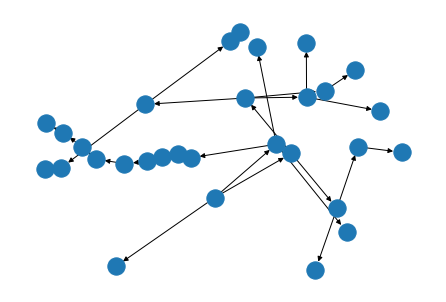

In [7]:
#pos = graphviz_layout(trees[0], prog='dot')
#nx.draw(trees[0], pos=pos)
nx.draw(trees[0])

Review article by Chi et al (2005) ["Frequent Subtree Mining — An Overview"](http://www.csc.lsu.edu/~jianhua/frequent-survey.pdf)